In [104]:
import pennylane as qml
import jax
from jax import numpy as jnp
#import jaxopt
import optax

import os
os.system("export OMP_NUM_THREADS=6")

jax.config.update("jax_platform_name", "cpu")

n_wires = 8
dev = qml.device("lightning.qubit", wires=n_wires)

def chebyshev_feature_map(x, n_wires = n_wires):
    for i in range(n_wires):
        qml.RY(2*jnp.arccos(x),wires = i)

@qml.qjit
@qml.qnode(dev, diff_method="adjoint")
def circuit(data, weights):
    """Quantum circuit ansatz"""

    # data embedding
    chebyshev_feature_map(data)
    
    # trainable ansatz
    # qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    for i in range(n_wires):
        qml.RX(weights[i, 0], wires=i)
        qml.RY(weights[i, 1], wires=i)
        qml.RX(weights[i, 2], wires=i)
        qml.CNOT(wires=[i, (i + 1) % n_wires])

    # we use a sum of local Z's as an observable since a
    # local Z would only be affected by params on that qubit.
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

@jax.jit
def my_model(data, weights, bias):
    vcircuit = jax.vmap(circuit, in_axes=(0,None))
    return vcircuit(data, weights) + bias
    #return circuit(data, weights) + bias

@jax.jit
def target_fnc(data):
    return jnp.sin(data*2*jnp.pi)

@jax.jit
def loss_boundary_fnc(data, weights, bias):
    u_0 = jnp.zeros(data.shape)
    u_pred = my_model(data, weights, bias)
    return jnp.mean((u_pred - u_0)**2)

@jax.jit
def loss_pde_fnc(data, weights, bias):
    # du_dx = jax.jacrev(my_model, argnums=0)(data, weights, bias)
    # du_dx_vec = jnp.array([du_dx(i, weights, bias) for i in data])
    u_pred = my_model(data, weights, bias)
    res = u_pred - target_fnc(data)
    return jnp.mean(res**2)

@jax.jit
def loss_fnc(params):
    data = jnp.linspace(0.0, 1.0, 21)
    targets = target_fnc(data)
    # predictions = my_model(data, params["weights"], params["bias"])
    # loss = jnp.mean((targets - predictions) ** 2)
    loss_pde = loss_pde_fnc(data, params["weights"], params["bias"])
    # loss_boundary = loss_boundary_fnc(jnp.zeros_like(data), params["weights"], params["bias"])
    loss_boundary = 0.0
    return loss_pde + loss_boundary

opt = optax.adam(learning_rate=0.01)

@jax.jit
def update_step_jit(i, args):
    params, opt_state, loss_history, print_training = args

    loss_val, grads = jax.value_and_grad(loss_fnc)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    loss_history.at[i].set(loss_val)

    def print_fn():
        jax.debug.print("Step: {i}  Loss: {loss_val}", i=i, loss_val=loss_val)

    # if print_training=True, print the loss every 5 steps
    jax.lax.cond((jnp.mod(i, 10) == 0) & print_training, print_fn, lambda: None)

    return (params, opt_state, loss_history, print_training)

@jax.jit
def optimization_jit(params, print_training=False):
    n_iter = 200
    opt_state = opt.init(params)
    loss_history = jnp.zeros(n_iter)
    # for i in range(1,101):
    #     args = (params, opt_state, print_training)
    #     (params, opt_state) = update_step_jit(i,args)
    #     loss_history.append(loss_fnc(params))
    args = (params, opt_state, loss_history, print_training)
    (params, opt_state, loss_history, print_training) = jax.lax.fori_loop(1, n_iter+1, update_step_jit, args)

    return params, opt_state, loss_history

key = jax.random.key(42)
key, weights_key = jax.random.split(key,2)

weights = jax.random.normal(weights_key,(n_wires,3))
# shape = qml.BasicEntanglerLayers.shape(n_layers=1, n_wires=8)
# weights = jax.random.normal(opt_variables_key, shape=shape)
bias = jnp.array(0.)
params = {"weights": weights, "bias": bias}

# %timeit -r1 -n1 optimization_jit(params, print_training=True)

In [107]:
# params, opt_state, loss_history = optimize(params, opt_state)
params, opt_state, loss_history = optimization_jit(params, print_training=True)

Step: 10  Loss: 0.05467212018331306
Step: 20  Loss: 0.037413118636089024
Step: 30  Loss: 0.025285594165049642
Step: 40  Loss: 0.01716194286893483
Step: 50  Loss: 0.011573380192848265
Step: 60  Loss: 0.007044644289371485
Step: 70  Loss: 0.0035592542870431084
Step: 80  Loss: 0.001627014868985608
Step: 90  Loss: 0.0007536270987640855
Step: 100  Loss: 0.0003481323774932074
Step: 110  Loss: 0.0001703743608362848
Step: 120  Loss: 0.00010541012332693433
Step: 130  Loss: 8.139650408127632e-05
Step: 140  Loss: 6.835445438169933e-05
Step: 150  Loss: 5.987160397621734e-05
Step: 160  Loss: 5.421080862186244e-05
Step: 170  Loss: 5.0087229338755076e-05
Step: 180  Loss: 4.6849862813544744e-05
Step: 190  Loss: 4.4198557602674414e-05
Step: 200  Loss: 4.194584571407607e-05


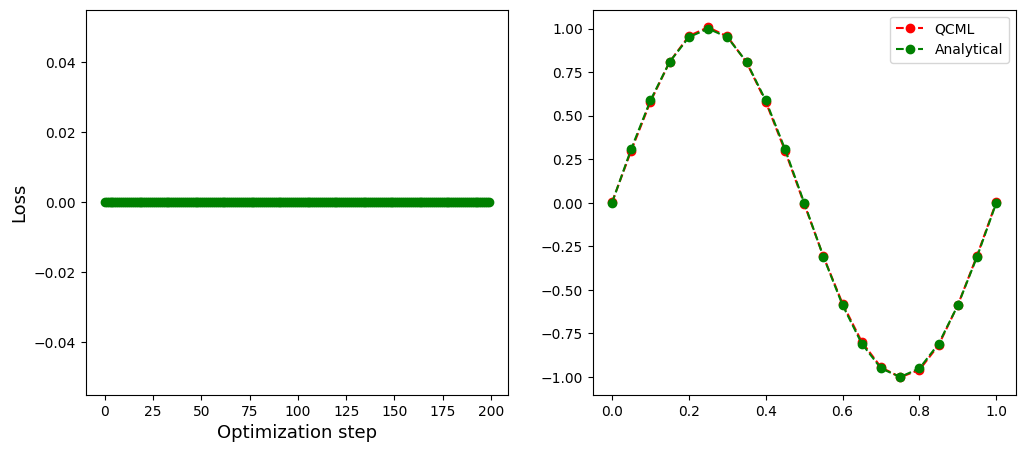

In [108]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(12)

# Add energy plot on column 1
ax1 = fig.add_subplot(121)
ax1.plot(range(len(loss_history)), loss_history, "go", ls="dashed")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("Loss", fontsize=13)

ax2 = fig.add_subplot(122)
x = jnp.linspace(0,1,21)
f_qc = my_model(x, params["weights"], params["bias"])
f_an = target_fnc(x)
ax2.plot( x, f_qc, "ro", ls="dashed")
ax2.plot( x, f_an, "go", ls="dashed")
ax2.legend(["QCML", "Analytical"])

plt.show()

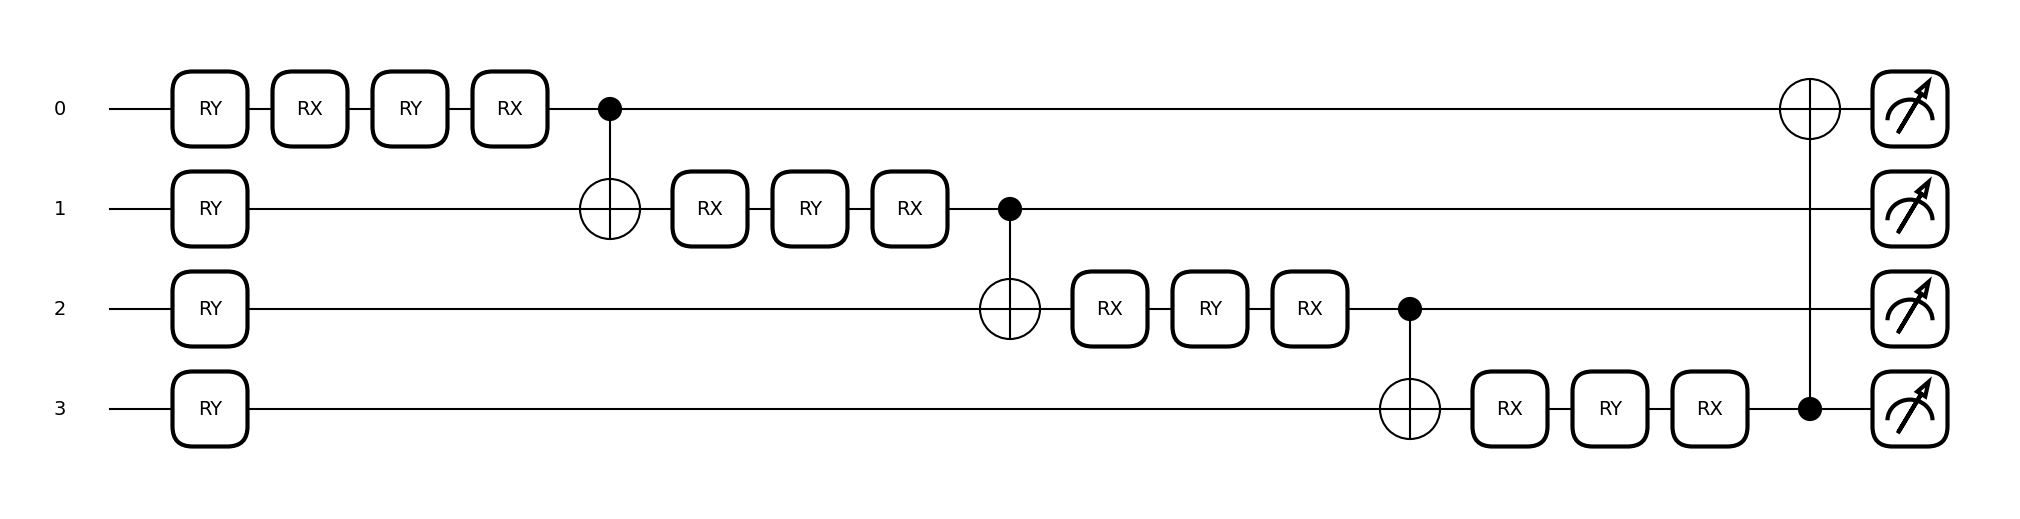

In [91]:
fig, ax = qml.draw_mpl(circuit)(1.0, weights)